In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math 
from tensorflow import keras


### Data Cleaning

In [2]:
dfuv = pd.read_csv("EcoTrans-AQIFinalDataSet - Uv Cleaned.csv")

In [3]:
dfuv.head()

,timestamp,Year,Month,Day,Time,Jakarta UV Radiation
0,20190101T0000,2019,1,1,0,0.0
1,20190101T0100,2019,1,1,1,0.0
2,20190101T0200,2019,1,1,2,0.0
3,20190101T0300,2019,1,1,3,0.0
4,20190101T0400,2019,1,1,4,0.0


In [4]:
dfuv.rename(columns = {"Jakarta UV Radiation":"JakartaUvRadiation"},inplace=True)


In [6]:
dfuv.groupby("Time")["JakartaUvRadiation"].mean()

Time
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.359781
7      9.241918
8     29.995890
9     55.072685
10    76.873425
11    91.412712
12    97.504740
13    93.908795
14    82.125041
15    63.605123
16    42.031178
17    20.014411
18     4.690822
19     0.028356
20     0.000000
21     0.000000
22     0.000000
23     0.000000
Name: JakartaUvRadiation, dtype: float64

In [7]:
dfuv = dfuv[   (dfuv["JakartaUvRadiation"] !=0)  & (dfuv["Time"]!= 6)  & (dfuv["Time"]!=18)  & (dfuv["Time"]!=7)  & (dfuv["Time"]!=19)]

In [8]:
dfuv = dfuv[   (dfuv["JakartaUvRadiation"] !=0)  & (dfuv["Time"]!= 6)  & (dfuv["Time"]!=19)]

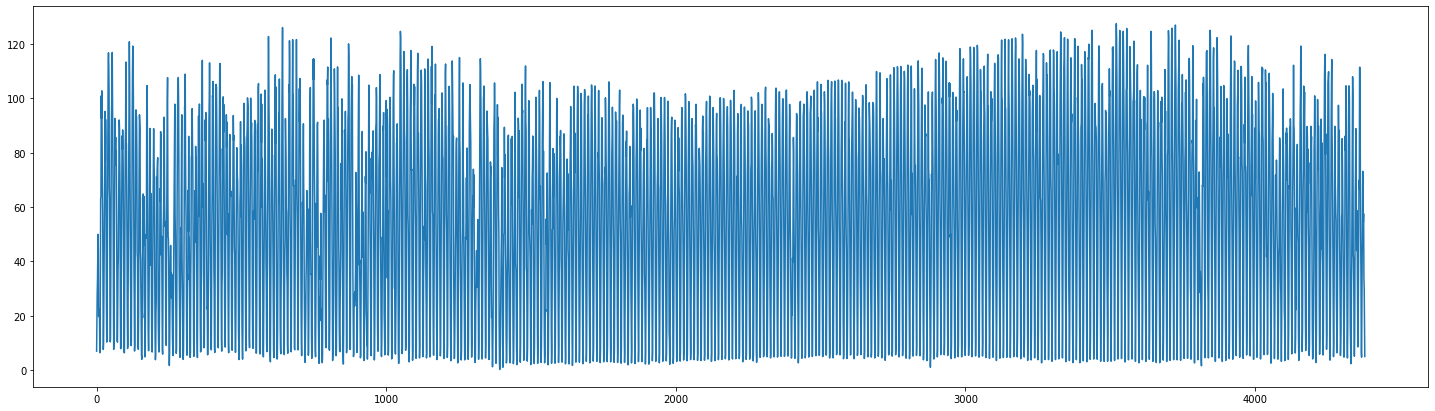

In [9]:
plt.figure(figsize = (25,7))
plt.plot(range(len(dfuv)), dfuv["JakartaUvRadiation"])

In [10]:
dfuv.groupby("Time")["JakartaUvRadiation"].mean()

Time
7      9.241918
8     29.995890
9     55.072685
10    76.873425
11    91.412712
12    97.504740
13    93.908795
14    82.125041
15    63.605123
16    42.031178
17    20.014411
18     4.690822
Name: JakartaUvRadiation, dtype: float64

In [11]:
dfuv = dfuv["JakartaUvRadiation"]

In [12]:
def split_counter(df,split_size):
  training = math.floor(len(df)*split_size)
  testing = math.floor(len(df) - training)

  training_set = df[:training]
  testing_set = df[training:]
  print("We have  {} for training and we have {} for testing".format(training,testing))


  return  training_set,testing_set

training_set, testing_set = split_counter(dfuv,0.9)

We have  3942 for training and we have 438 for testing


In [15]:
a = np.array(training_set)

In [16]:
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 72
batch_size = 128
train_set = windowed_dataset(a, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(a.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 127)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3942,)
Epoch 1/100
31/31 [==============================] - 16s 29ms/step - loss: 50.0218 - mae: 50.5167 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 49.2169 - mae: 49.7118 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 48.3507 - mae: 48.8468 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 47.4675 - mae: 47.9643 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 46.5565 - mae: 47.0531 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 45.6156 - mae: 46.1123 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 38ms/step - loss: 44.6455 - mae: 45.1427 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============

(1e-08, 0.0001, 0.0, 60.0)

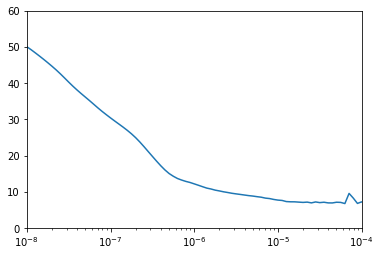

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])


In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(a, window_size=72, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 127)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=300)
                                    

Epoch 1/300
39/39 [==============================] - 4s 23ms/step - loss: 29.4688 - mae: 29.9658
Epoch 2/300
39/39 [==============================] - 1s 22ms/step - loss: 12.2702 - mae: 12.7612
Epoch 3/300
39/39 [==============================] - 1s 22ms/step - loss: 9.5679 - mae: 10.0548
Epoch 4/300
39/39 [==============================] - 1s 22ms/step - loss: 8.7389 - mae: 9.2244
Epoch 5/300
39/39 [==============================] - 1s 22ms/step - loss: 8.0684 - mae: 8.5518
Epoch 6/300
39/39 [==============================] - 1s 23ms/step - loss: 7.7425 - mae: 8.2256
Epoch 7/300
39/39 [==============================] - 1s 24ms/step - loss: 7.5230 - mae: 8.0056
Epoch 8/300
39/39 [==============================] - 1s 21ms/step - loss: 7.3457 - mae: 7.8273
Epoch 9/300
39/39 [==============================] - 1s 22ms/step - loss: 7.2334 - mae: 7.7151
Epoch 10/300
39/39 [==============================] - 1s 25ms/step - loss: 7.0781 - mae: 7.5586
Epoch 11/300
39/39 [========================

In [26]:
datas= np.array(dfuv)
datas


array([ 6.89, 18.02, 27.46, ..., 30.18, 16.9 ,  4.94])

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, datas[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[(len(training_set) - window_size):-1, -1, 0]



In [28]:
rnn_forecast

array([104.6371   ,  81.13298  ,  62.887413 ,  38.81939  ,  19.152575 ,
         4.001215 ,  13.503183 ,  43.367073 ,  71.189964 ,  92.28856  ,
       106.2638   , 110.28329  , 104.51371  ,  88.65093  ,  62.736458 ,
        43.18023  ,  20.378832 ,   4.766587 ,  20.290415 ,  44.879173 ,
        68.39617  ,  89.36187  , 100.995544 ,  94.53891  ,  97.703865 ,
        76.5927   ,  59.365257 ,  41.20532  ,  20.05366  ,   4.59804  ,
        10.264738 ,  37.77575  ,  65.168884 ,  89.3011   , 101.72229  ,
       109.59528  , 106.681335 ,  90.05441  ,  67.69492  ,  42.929306 ,
        20.500275 ,   4.384603 ,  16.5736   ,  41.197304 ,  68.23713  ,
        91.79958  ,  99.32993  , 102.01237  , 102.89078  ,  79.408875 ,
        66.88872  ,  42.480316 ,  20.23539  ,   3.4058056,  13.46737  ,
        37.425354 ,  66.2687   ,  80.2924   ,  95.17032  ,  85.15401  ,
        78.390335 ,  80.47872  ,  65.18976  ,  27.502071 ,  15.81201  ,
         5.8130083,  20.042694 ,  41.13114  ,  66.0276   ,  86.8

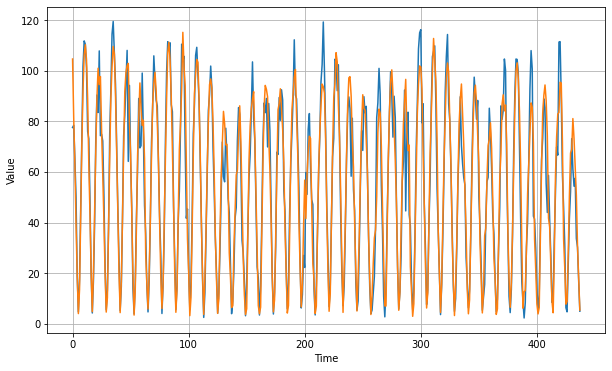

In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(range(len(testing_set)), testing_set)
plot_series(range(len(testing_set)), rnn_forecast)

In [30]:
tf.keras.metrics.mean_absolute_error(testing_set, rnn_forecast).numpy()

7.478173

In [31]:
#Making dataframe
frames = {"Uv":testing_set, "Uv-Forcast": rnn_forecast}
dfforecast = pd.DataFrame(frames)
dfforecast

,Uv,Uv-Forcast
7885,77.56,104.637100
7886,78.41,81.132980
7887,65.00,62.887413
7888,50.03,38.819389
7889,19.05,19.152575
...,...,...
8750,57.53,61.848263
8751,33.71,50.780998
8752,30.18,30.654167
8753,16.90,17.589487


In [32]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!mkdir -p saved_model

In [33]:
model.save('saved_model/UvRadiation2')

INFO:tensorflow:Assets written to: saved_model/UvRadiation2/assets


INFO:tensorflow:Assets written to: saved_model/UvRadiation2/assets


In [35]:
UvModel = tf.keras.models.load_model('/gdrive/MyDrive/saved_model/UvRadiation2')
# Check its architecture
UvModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 dense (Dense)               (None, None, 60)          7740      
                                                                 
 dropout (Dropout)           (None, None, 60)          0         
                                                                 
 dense_1 (Dense)             (None, None, 10)          610       
                                                                 
 dense_2 (Dense)             (None, None, 1)           1

In [38]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, datas[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[(len(training_set) - window_size):-1, -1, 0]


In [39]:
rnn_forecast

array([104.6371   ,  81.13298  ,  62.887413 ,  38.81939  ,  19.152575 ,
         4.001215 ,  13.503183 ,  43.367073 ,  71.189964 ,  92.28856  ,
       106.2638   , 110.28329  , 104.51371  ,  88.65093  ,  62.736458 ,
        43.18023  ,  20.378832 ,   4.766587 ,  20.290415 ,  44.879173 ,
        68.39617  ,  89.36187  , 100.995544 ,  94.53891  ,  97.703865 ,
        76.5927   ,  59.365257 ,  41.20532  ,  20.05366  ,   4.59804  ,
        10.264738 ,  37.77575  ,  65.168884 ,  89.3011   , 101.72229  ,
       109.59528  , 106.681335 ,  90.05441  ,  67.69492  ,  42.929306 ,
        20.500275 ,   4.384603 ,  16.5736   ,  41.197304 ,  68.23713  ,
        91.79958  ,  99.32993  , 102.01237  , 102.89078  ,  79.408875 ,
        66.88872  ,  42.480316 ,  20.23539  ,   3.4058056,  13.46737  ,
        37.425354 ,  66.2687   ,  80.2924   ,  95.17032  ,  85.15401  ,
        78.390335 ,  80.47872  ,  65.18976  ,  27.502071 ,  15.81201  ,
         5.8130083,  20.042694 ,  41.13114  ,  66.0276   ,  86.8